### Exercise 5

#### 3. Constructing the Matrix X (25 points)

In [450]:
# import modules
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
plt.rc('image', cmap='gray')

In [454]:
def contruct_X(M, alphas, Np = None):
    
    h = 1 # pixel distance
    num_p = np.size(alphas) # determine number of projection angles
    
    if Np == None:
        Np = np.ceil(np.sqrt(2)*M) # set number of detector sensors if none is given
        
    N = num_p*Np # dimensions of Matrix X (N*D)
    D = M*M
        
    # convert angles to radians
    alphas = 2*np.pi*alphas/360
    
    # construct coordinates of of first pixel
    coord = (M-1)*h/2
    
    # construct coordinates of pixel centers
    JJ = np.mgrid[-coord:coord+1,-coord:coord+1]
    C0j = JJ[1].reshape((1,M*M))
    C1j = np.flip(JJ[0]).reshape((1,M*M))
    C01j = np.concatenate((C0j,C1j))
        
    n = np.array([np.cos(alphas), np.sin(alphas)]) # unit vector for all angles
    
    s0 = (Np-1)*h/2 # length between first and center sensor element
    
    p = np.dot(n.T,C01j) + s0 # projection
    
    sen1 = np.floor(p)
    sen2 = np.ceil(p)
    w1 = (sen2 - p).flatten()
    w2 = (p - sen1).flatten()
    
    T = np.mgrid[0:num_p,0:M*M]
    SEN1 = (sen1 + np.dot(T[0],Np)).flatten()
    SEN2 = (sen2 + np.dot(T[0],Np)).flatten()
    H = np.mgrid[0:num_p, 0:D]
    im_pix = np.concatenate((H[1].flatten(), H[1].flatten()))
    
    sensors = np.array([SEN1,SEN2]).flatten()
    weights = np.array([w1,w2]).flatten()
    
    X = coo_matrix((weights, (sensors, im_pix)), shape=(int(N), int(D)), dtype = np.float32)
    return X

<span style ="color:green;font-weight:bold ">Comments:  
    - Our code is more efficient as it does not use any loops to create the projection matrix  
    - Did not look at the case if projected only onto one sensor (sen1 = sen2)
    - </span >

Square Deviation of the two matrices is: 0.0


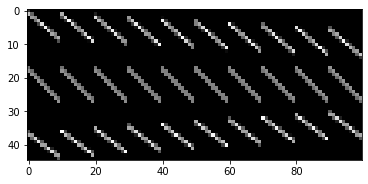

In [455]:
M = 10
alphas = np.array([-33, 1, 42])
X = contruct_X(M,alphas)

X_np = X.toarray()
plt.imshow(X_np)

X_example = np.load('hs_tomography/X_example.npy')
# comparison
comp = np.sqrt(np.sum((X_np-X_example)**2)/np.size(X_np)) # square deviation
print('Square Deviation of the two matrices is:', comp)

<span style ="color:green;font-weight:bold ">Changes that should be made:  
    -  provided a way to compare our determined matrix X with the given matrix X through the square deviation. </span >

#### 4 Recovering the Image

In [461]:
# reconstruct an image
def reconstruct(y, alphas, M, Np = None, X = None):
    
    if X == None:
        # contruct projection matrices
        X = contruct_X(M, alphas, Np)
    
    # calculate and display sparsity
    sparsity_X = sparsity(X)
    print('The sparsity of Matrix X with M =', M, 'is', sparsity_X*100, '%')
    
    # convert to csc matrix
    X_csc = X.tocsc()
    
    # reconstruct original image
    im = lsqr(X, y, atol=1e-08, btol=1e-08)
    
    # reshape image
    IM = im[0].reshape((M, M))
    return IM

In [462]:
# calculates the sparsity of a matrix
def sparsity(X): # input is a sparse matrix
    nonzero = np.shape(X.nonzero())
    sparsity = 1 - nonzero[1]/np.size(X.toarray())
    return sparsity

<span style ="color:green;font-weight:bold ">Changes that should be made:  
    -  Sparsity was not determined in the example code. </span >

In [463]:
# load data
a_77 = np.load('hs_tomography/alphas_77.npy')
a_195 = np.load('hs_tomography/alphas_195.npy')
y_77 = np.load('hs_tomography/y_77.npy')
y_195 = np.load('hs_tomography/y_195.npy')

In [464]:
M_77 = 77
Np_77 = 109
num_p_77 = 90
M_195 = 195
Np_195 = 275
num_p_195 = 179

IM_77 = reconstruct(y_77, a_77, M_77, Np_77)
IM_195 = reconstruct(y_195, a_195, M_195, Np_195)

The sparsity of Matrix X with M = 77 is 98.16588722581811 %
The sparsity of Matrix X with M = 195 is 99.28095398465832 %


<span style ="color:green;font-weight:bold ">Changes that should be made:  
    -  The code to display the images, load the data and the function to solve the system of linear equation are essentially the same.  
    - Something went wrong in this code while centering the pixel or centering the detector. An easy way to change this would have been to distinguish between an even number of sensors and an uneven number of sensors. </span >

Text(0.5, 1.0, 'Image with M = 195')

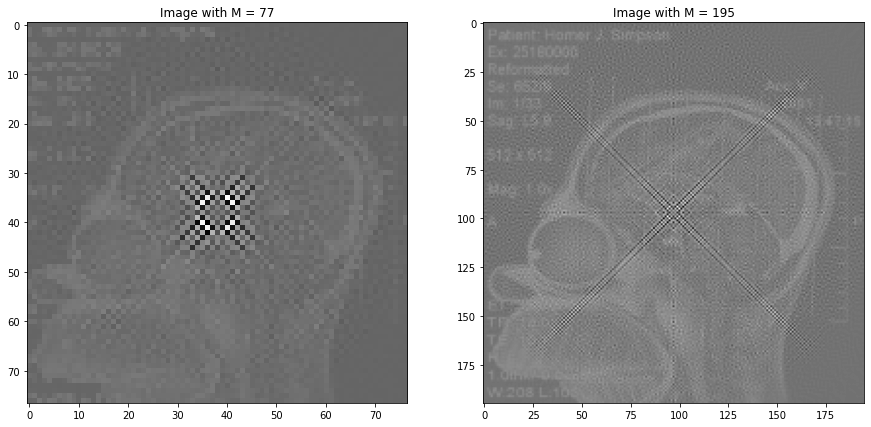

In [465]:
# display image

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,15))
ax1.imshow(IM_77)
ax1.set_title('Image with M = 77')
ax2.imshow(IM_195)
ax2.set_title('Image with M = 195')

Diagnosis: Cannot be seen that well in this skript, but from the solutions of the others in this group, it appear as though Homer has a crayon in his head. (We couldn't really figure out why this skript did not work properly. It must have something to do with the centering of the coordinate system that is not done properly for M uneven).

Treatment: If it is hazardous to his health, he should get it removed sugically.

#### 5 Minimizing the radiation dose

In [466]:
def reconstruct_w_nth_alphas(alphas, y, n, M, num_p, Np):
    y_ = y.reshape(num_p, Np)[0::n.flatten] # reshape response vector
    
    alphas_n = alphas[0::n]
    IM = reconstruct(y_n, alphas_n, M, Np)
    return IM

In [468]:
n = np.array([2,3,4,5])

IM_195 = np.zeros((np.size(n), M_195, M_195))

for ii in range(0,np.size(n)):
    IM_195[ii,:,:] = reconstruct_wo_nth_alphas(a_195, y_195, n[ii], M_195, num_p_195, Np_195)

The sparsity of Matrix X with M = 195 is 99.27282892081509 %
The sparsity of Matrix X with M = 195 is 99.27274639890025 %
The sparsity of Matrix X with M = 195 is 99.27825559311208 %
The sparsity of Matrix X with M = 195 is 99.27274639890025 %


Text(0.5, 1.0, 'Image with every 5th angle')

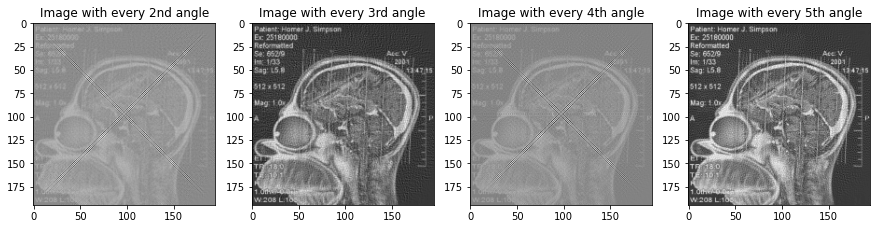

In [476]:
fig, axs = plt.subplots(1,4,figsize = (15,15))
axs[0].imshow(IM_195[0,:,:])
axs[0].set_title('Image with every 2nd angle')
axs[1].imshow(IM_195[1,:,:])
axs[1].set_title('Image with every 3rd angle')
axs[2].imshow(IM_195[2,:,:])
axs[2].set_title('Image with every 4th angle')
axs[3].imshow(IM_195[3,:,:])
axs[3].set_title('Image with every 5th angle')

Even when using every fifth angle the crayon can still be seen, but maybe not recognized as a crayon.

<span style ="color:green;font-weight:bold ">Changes that should be made:  
    - A better respresentation of how the image changes is shown in the sample solution as it goes from 1 angles and increases the number of projections. This is a better way to understand how the image is constructed. The sample solution always doubles the number of angles.  
    - Just like in the sample solution we kept that fact that the angles are distributed over 180 degrees as otherwise the reconstruction can always be improved without changing the number of projections, just by changing the angles of the projection.  
    -  Here the problem there is the same problem for the image reconstruction as in the last part, but we realize that the problem does not eaxist when there is an uneven amount of projections. </span >